#FOR CUSP PUI2015
#KRIGING
#ONLY MINOR MODIFICATIONS FROM 
#Connor Johnson
#http://connor-johnson.com/2014/03/20/simple-kriging-in-python/

Populating the interactive namespace from numpy and matplotlib


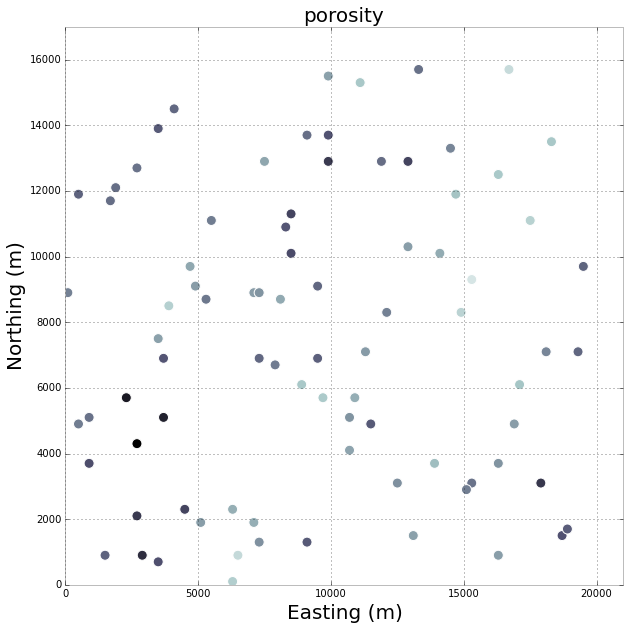

In [34]:
import numpy as np
import pylab as pl
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import json
import os
s = json.load( open(os.getenv ('PUI2015')+"/fbb_matplotlibrc.json") )
pl.rcParams.update(s)

%pylab inline

x=np.load("porosoty.npy")
x = x[:,[0,1,3]]
yy=x[:,2]
ax = pl.figure(figsize=(10,10), dpi=150).add_subplot(111)
pl.scatter(x[:,0], x[:,1], c=x[:,2], s=100, cmap='bone')
pl.ylim(0, 17000)
pl.xlim(0, 21000)
pl.xlabel("Easting (m)", fontsize=20)
pl.ylabel("Northing (m)", fontsize=20)
pl.title("porosity", fontsize=20)

#the semivariogram is a measure of spatial consistency

$\hat{\gamma}(h) = \dfrac{1}{2N(h)} \displaystyle \sum_{N(h)} ( z_{i} - z_{j} )^{2}$


In [35]:
def SVh_vctzd( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N
    
    #print pd
    Z = np.zeros((N,N))
    Z = Z-P[:,2]
    Z = Z.T+P[:,2]
    Z=Z**2
    Zcd =  Z[np.array((np.triu_indices(N))>0) * \
            (pdsv >= h-bw) * (pdsv <= h+bw) * \
            (~np.identity(N, dtype=bool))]

    #print Z
    return np.sum( Zcd ) / ( 2.0 * len( Zcd ) )

def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N
    
    #print pd
    Z = list()
    for i in range(N):
        for j in range(i+1,N):
            if( pdsv[i,j] >= h-bw )and( pdsv[i,j] <= h+bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    #print Z
    return np.sum( Z ) / ( 2.0 * len( Z ) )


def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        #print hs
        #sv.append( SVh( P, h, bw ) )
        sv.append( SVh_vctzd ( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T



In [36]:
%timeit -n 1000 mysv = SVh( x, 1000, 500 )


1000 loops, best of 3: 3.34 ms per loop


In [37]:
print  SVh( x, 1000, 500 )


0.303413649928


In [38]:
%timeit -n 1000 mysv = SVh_vctzd( x, 1000, 500 )


1000 loops, best of 3: 360 µs per loop


In [39]:
mysv = SV( x, np.arange(1,10000,500), 500 )
print mysv

[[  1.00000000e+00   5.01000000e+02   1.00100000e+03   1.50100000e+03
    2.00100000e+03   2.50100000e+03   3.00100000e+03   3.50100000e+03
    4.00100000e+03   4.50100000e+03   5.00100000e+03   5.50100000e+03
    6.00100000e+03   6.50100000e+03   7.00100000e+03   7.50100000e+03
    8.00100000e+03   8.50100000e+03   9.00100000e+03   9.50100000e+03]
 [  1.93610567e-02   2.43717617e-01   3.03413650e-01   4.69954601e-01
    5.94118713e-01   5.80495882e-01   6.74678760e-01   6.61392539e-01
    7.03805028e-01   7.59232498e-01   8.51608003e-01   8.11368372e-01
    7.28368804e-01   7.63392777e-01   7.63355238e-01   7.41170013e-01
    7.11677625e-01   7.59823026e-01   7.45265546e-01   7.22727921e-01]]


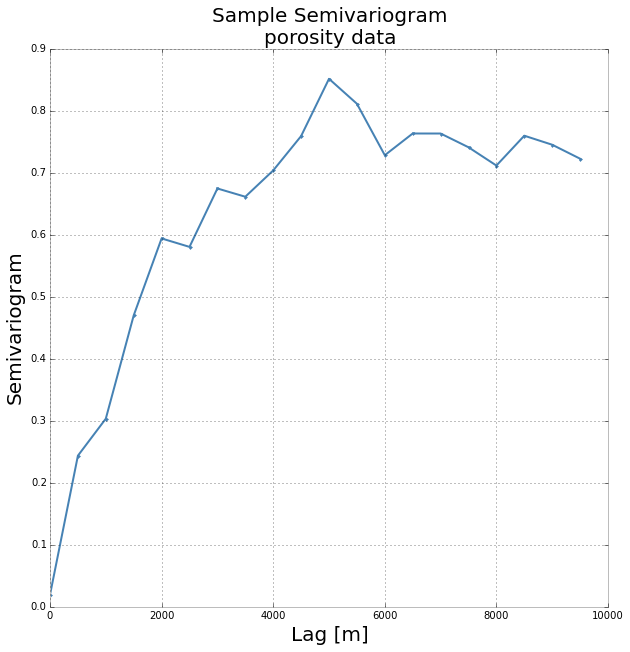

In [40]:
bw = 500
# lags in 500 meter increments from zero to 10,000
hs = np.arange(0,10500,bw)
#mysv = SV( x, hs, bw )
pl.figure(figsize=(10,10))
plot( mysv[0], mysv[1], '.-' )
xlabel('Lag [m]', fontsize=20)
ylabel('Semivariogram', fontsize=20)
title('Sample Semivariogram\nporosity data', fontsize=20) ;


##Now we need to model the semi-variogram. 
#we can do that with a number of functions: spherica, gaussian, exponential. 

what we do mathematically is solving a MSE problem: it can be shown that the optimal model is one that minimizes

$MSE = Cov(Z_0,Z_0) - 2\lambda_jCov(Z_0,Z_j) + \sum_I \sum_j \lambda_i \lambda_j Cov(Z_i,Z_j)$ 

so we want to find the 

$\lambda's | \frac{d MSE}{d\lambda_k} = 0$

and that is 

$\sum \lambda_j ~Cov(k,j) = Cov(0,k)$

In [41]:

def opt( fct, x, y, C0, meshSize=1000 ):
    parameterRange = [ x[1], x[-1] ]
    mse = np.zeros( meshSize )
    a = np.linspace( parameterRange[0], parameterRange[1], meshSize )
    for i in range( meshSize ):
        mse[i] = np.mean( ( y - fct( x, a[i], C0 ) )**2.0 )
    return a[ mse.argmin() ]        


def spherical( h, a, C0 ):
    #print "sph"

    '''
    Spherical model of the semivariogram
    '''
    # if h is a single digit

    
    if type(h) == np.float64:
        # calculate the spherical function
        if h <= a:
            return C0*( 1.5*h/a - 0.5*(h/a)**3.0 )
        else:
            return C0
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( spherical, h, a, C0 )

def exponentialngt(h, a, C0):
    #print "exp"
    '''
    Spherical model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        return C0 - exp(-h/a)
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( exponentialngt, h, a, C0 )

    
def gaussianngt(h, a, C0):
    #print "exp"
    '''
    Spherical model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        return C0 - exp(-(h/a)**2)
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( exponentialngt, h, a, C0 )



def C( P, h, bw ):
    '''
    Calculate the sill
    '''
    c0 = np.var( P[:,2] )
    if h == 0:
        return c0
    return c0 - SVh( P, h, bw )



def cvmodel( P, model, hs, bw ):
    '''
    Input:  (P)      ndarray, data
            (model)  modeling function
                      - spherical
                      - exponentialngt
                      - gaussian
            (hs)     distances
            (bw)     bandwidth
    Output: (covfct) function modeling the covariance
    '''
    # calculate the semivariogram
    sv = SV( P, hs, bw )
    # calculate the sill
    C0 = C( P, hs[0], bw )
    #print C0
    # calculate the optimal parameters
    param = opt( model, sv[0], sv[1], C0 )
    # return a covariance function
    covfct = lambda h, a = param: C0 - model( h, a, C0 )
    return covfct


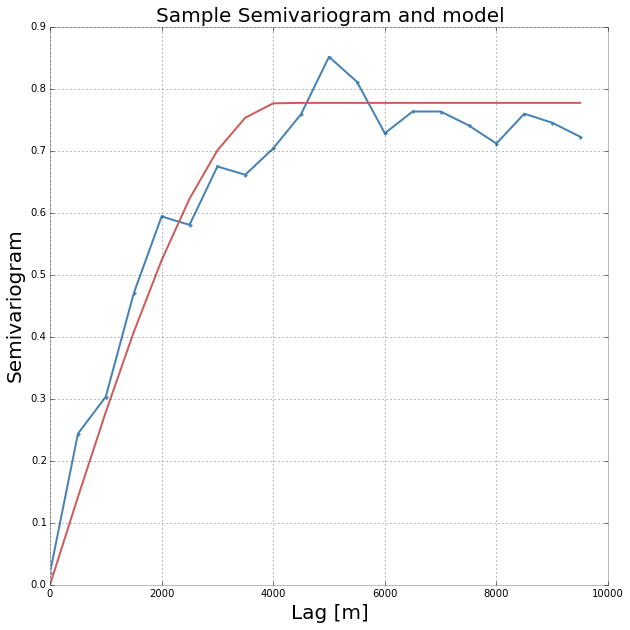

In [42]:
pl.figure(figsize=(10,10))
sp = cvmodel( x, model=spherical, 
             hs=np.arange(0,10000, 100 ), bw=bw)
#print sp(mysv[0])
sphere = sp(mysv[0])
plot( mysv[0], mysv[1], '.-' )
pl.plot(mysv[0], -sphere+sphere.max())
xlabel('Lag [m]', fontsize=20)
ylabel('Semivariogram', fontsize=20)
title('Sample Semivariogram and model', fontsize=20) ;


In [43]:
def krige( P, model, hs, bw, u, N ):
    '''
    Input  (P)     ndarray, data
           (model) modeling function
                    - spherical
                    - exponential
                    - gaussian
           (hs)    kriging distances
           (bw)    kriging bandwidth
           (u)     unsampled point
           (N)     number of neighboring
                   points to consider
    '''
    # covariance function
    covfct = cvmodel( P, model, hs, bw )
    # mean of the variable
    mu = np.mean( P[:,2] )
 
    # distance between u and each data point in P
    d = np.sqrt( ( P[:,0]-u[0] )**2.0 + ( P[:,1]-u[1] )**2.0 )
    # add these distances to P
    P = np.vstack(( P.T, d )).T
    # sort P by these distances
    # take the first N of them
    P = P[d.argsort()[:N]]
 
    # apply the covariance model to the distances
    k = covfct( P[:,3] )
    # cast as a matrix
    k = np.matrix( k ).T
 
    # form a matrix of distances between existing data points
    K = squareform( pdist( P[:,:2] ) )
    # apply the covariance model to these distances
    K = covfct( K.ravel() )
    # re-cast as a NumPy array -- thanks M.L.
    K = np.array( K )
    # reshape into an array
    K = K.reshape(N,N)
    # cast as a matrix
    K = np.matrix( K )
 
    # calculate the kriging weights
    weights = np.linalg.inv( K ) * k
    weights = np.array( weights )
 
    # calculate the residuals
    residuals = P[:,2] - mu
 
    # calculate the estimation
    estimation = np.dot( weights.T, residuals ) + mu
 
    return float( estimation )

In [44]:
import time
print time.localtime()

x0, x1 = x[:,0].min(), x[:,0].max()
y0, y1 = x[:,1].min(), x[:,1].max()
z=np.zeros((8,10))
dx, dy = (x1-x0)/z.shape[1], (y1-y0)/z.shape[0]

for i in range(z.shape[0]):
    print i
    for j in range(z.shape[1]):
        z[i][j] = krige(x, spherical, hs, bw, (dy*j,dx*i), 3)
        
print time.localtime()

time.struct_time(tm_year=2015, tm_mon=12, tm_mday=9, tm_hour=20, tm_min=14, tm_sec=37, tm_wday=2, tm_yday=343, tm_isdst=0)
0
1
2
3
4
5
6
7
time.struct_time(tm_year=2015, tm_mon=12, tm_mday=9, tm_hour=20, tm_min=14, tm_sec=47, tm_wday=2, tm_yday=343, tm_isdst=0)


([<matplotlib.axis.YTick at 0x110cc5f50>,
 <a list of 3 Text yticklabel objects>)

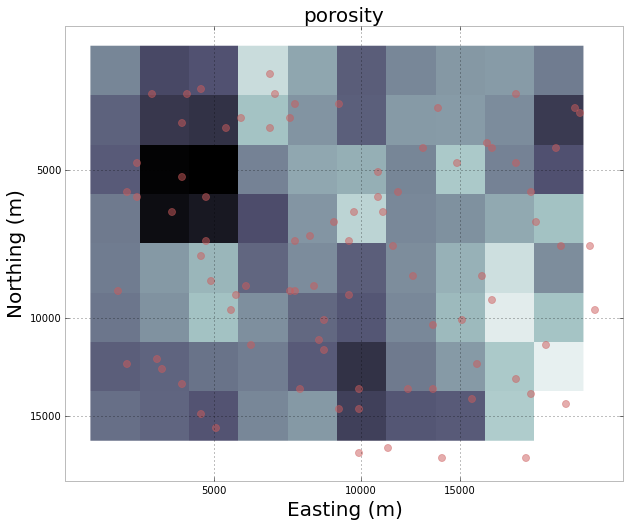

In [45]:
ax = pl.figure(figsize=(10,10)).add_subplot(111)
H = np.zeros_like( z)
for i in range( z.shape[0] ):
    for j in range( z.shape[1] ):
        H[i,j] = np.round( z[i,j]*3 )
        
ax.imshow( z, cmap='bone', interpolation='nearest' )
ax.scatter( x[:,0]/2000.0, x[:,1]/2000.0, color = 'IndianRed', alpha = 0.5, 
           linewidths=0.75, s=50 )
#xlim(0,99) ; ylim(0,89)
#ax.axis('off')
pl.xlabel("Easting (m)", fontsize=20)
pl.ylabel("Northing (m)", fontsize=20)
pl.title("porosity", fontsize=20)
xticks( [2,5.0,7], [5000,10000,15000] )
yticks( [2,5.0,7], [5000,10000,15000] )

In [46]:
import time
print time.localtime()

x0, x1 = x[:,0].min(), x[:,0].max()
y0, y1 = x[:,1].min(), x[:,1].max()
z=np.zeros((40,50))
dx, dy = (x1-x0)/z.shape[1], (y1-y0)/z.shape[0]

for i in range(z.shape[0]):
    print i
    for j in range(z.shape[1]):
        z[i][j] = krige(x, spherical, hs, bw, (dy*j,dx*i), 3)
        
print time.localtime()

time.struct_time(tm_year=2015, tm_mon=12, tm_mday=9, tm_hour=20, tm_min=14, tm_sec=47, tm_wday=2, tm_yday=343, tm_isdst=0)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
time.struct_time(tm_year=2015, tm_mon=12, tm_mday=9, tm_hour=20, tm_min=16, tm_sec=48, tm_wday=2, tm_yday=343, tm_isdst=0)


([<matplotlib.axis.YTick at 0x110cf3490>,
 <a list of 3 Text yticklabel objects>)

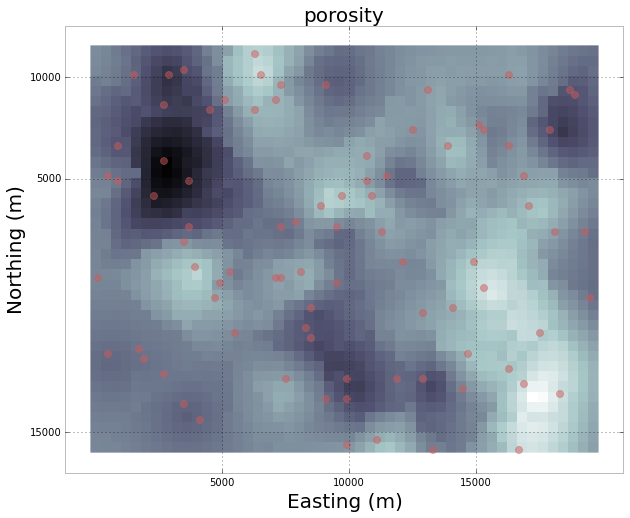

In [47]:
ax = pl.figure(figsize=(10,10)).add_subplot(111)
H = np.zeros_like( z)
for i in range( z.shape[0] ):
    for j in range( z.shape[1] ):
        H[i,j] = np.round( z[i,j]*3 )
        
pl.imshow( z, cmap='bone', interpolation='nearest' )

ax.scatter( x[:,0]/400.0, x[:,1]/400.0, color = 'IndianRed', alpha = 0.5, 
           linewidths=0.75, s=50 )
#xlim(0,99) ; ylim(0,89)
#ax.axis('off')
pl.xlabel("Easting (m)", fontsize=20)
pl.ylabel("Northing (m)", fontsize=20)
pl.title("porosity", fontsize=20)
xticks( [12.5,25.0,37.5], [5000,10000,15000] )
yticks( [12.5,2.50,37.5], [5000,10000,15000] )


In [48]:
z2=np.zeros_like((z))
H2 = np.zeros_like( z)
for i in range(z2.shape[0]):
    print i
    for j in range(z2.shape[1]):
        z2[i][j] = krige(x, gaussianngt, hs, bw, (dy*j,dx*i), 3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


([<matplotlib.axis.YTick at 0x1112cd210>,
 <a list of 3 Text yticklabel objects>)

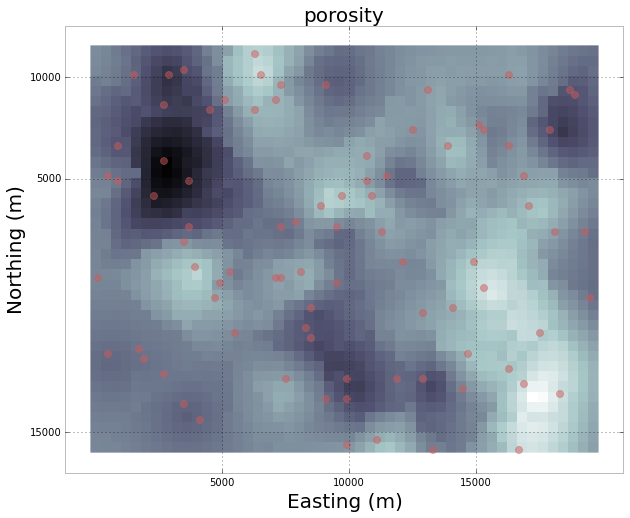

In [49]:
ax = pl.figure(figsize=(10,10)).add_subplot(111)
H = np.zeros_like( z)
for i in range( z.shape[0] ):
    for j in range( z.shape[1] ):
        H[i,j] = np.round( z[i,j]*3 )
        
ax.imshow( z, cmap='bone', interpolation='nearest' , clim=(min(z.flatten()), max(z.flatten())))
ax.scatter( x[:,0]/400.0, x[:,1]/400.0, color = 'IndianRed', alpha = 0.5, 
           linewidths=0.75, s=50 )
#xlim(0,99) ; ylim(0,89)
#ax.axis('off')
pl.xlabel("Easting (m)", fontsize=20)
pl.ylabel("Northing (m)", fontsize=20)
pl.title("porosity", fontsize=20)
xticks( [12.5,25.0,37.5], [5000,10000,15000] )
yticks( [12.5,2.50,37.5], [5000,10000,15000] )


([<matplotlib.axis.YTick at 0x11158f090>,
 <a list of 3 Text yticklabel objects>)

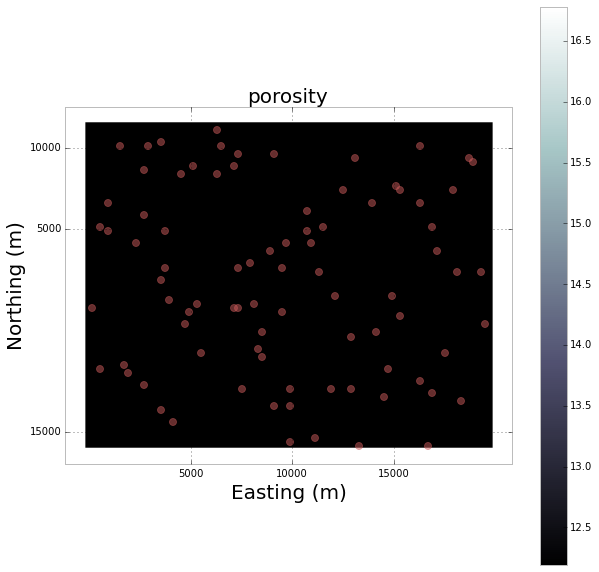

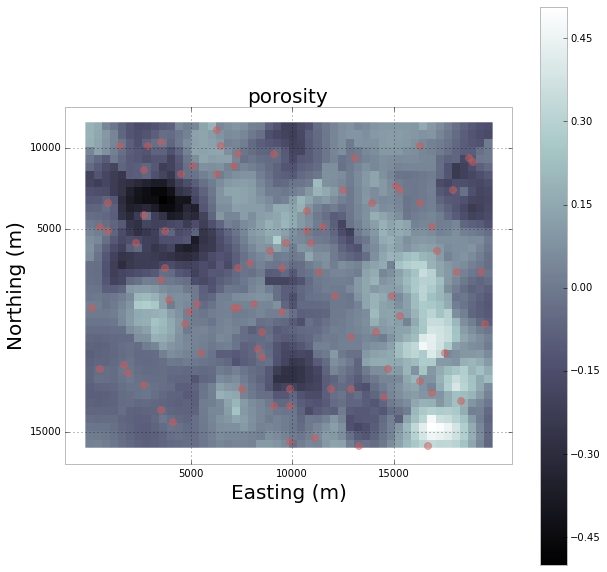

In [50]:
#the difference between the spherical and gaussian kernel
H = np.zeros_like( z)
for i in range( z.shape[0] ):
    for j in range( z.shape[1] ):
        H[i,j] = np.round( z[i,j]*3 )
ax = pl.figure(figsize=(10,10)).add_subplot(111)
        
pl.imshow( z-z2, cmap='bone', interpolation='nearest' , clim=(min(z.flatten()), max(z.flatten())))
pl.colorbar()
ax.scatter( x[:,0]/400.0, x[:,1]/400.0, color = 'IndianRed', alpha = 0.5, 
           linewidths=0.75, s=50 )
#xlim(0,99) ; ylim(0,89)
#ax.axis('off')

pl.xlabel("Easting (m)", fontsize=20)
pl.ylabel("Northing (m)", fontsize=20)
pl.title("porosity", fontsize=20)
xticks( [12.5,25.0,37.5], [5000,10000,15000] )
yticks( [12.5,2.50,37.5], [5000,10000,15000] )

ax = pl.figure(figsize=(10,10)).add_subplot(111)
        
pl.imshow( z-z2, cmap='bone', interpolation='nearest' )
pl.colorbar()
ax.scatter( x[:,0]/400.0, x[:,1]/400.0, color = 'IndianRed', alpha = 0.5, 
           linewidths=0.75, s=50 )
#xlim(0,99) ; ylim(0,89)
#ax.axis('off')

pl.xlabel("Easting (m)", fontsize=20)
pl.ylabel("Northing (m)", fontsize=20)
pl.title("porosity", fontsize=20)
xticks( [12.5,25.0,37.5], [5000,10000,15000] )
yticks( [12.5,2.50,37.5], [5000,10000,15000] )

In [51]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcess

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


#------------------------------------------------------------
# define a squared exponential covariance function
def squared_exponential(x1, x2, h):
    return np.exp(-0.5 * (x1 - x2) ** 2 / h ** 2)

#------------------------------------------------------------
# draw samples from the unconstrained covariance
np.random.seed(1)
xx = np.linspace(0, 10, 100)
h = 1.0

mu = np.zeros(len(xx))
CC = squared_exponential(xx, xx[:, None], h)
draws = np.random.multivariate_normal(mu, C, 3)

#------------------------------------------------------------
# Constrain the mean and covariance with two points
x1 = np.array([2.5, 7])
y1 = np.cos(x1)
gp1 = GaussianProcess(corr='squared_exponential', theta0=0.5,
                      random_state=0)
gp1.fit(x1[:, None], y1)
f1, MSE1 = gp1.predict(xx[:, None], eval_MSE=True)
f1_err = np.sqrt(MSE1)

#------------------------------------------------------------
# Constrain the mean and covariance with two noisy points
#  scikit-learn gaussian process uses nomenclature from the geophysics
#  community, where a "nugget" can be specified.  The diagonal of the
#  assumed covariance matrix is multiplied by the nugget.  This is
#  how the error on inputs is incorporated into the calculation
dy2 = 0.2
gp2 = GaussianProcess(corr='squared_exponential', theta0=0.5,
                      nugget=(dy2 / y1) ** 2, random_state=0)
gp2.fit(x1[:, None], y1)
f2, MSE2 = gp2.predict(xx[:, None], eval_MSE=True)
f2_err = np.sqrt(MSE2)


#------------------------------------------------------------
# Constrain the mean and covariance with many noisy points
x3 = np.linspace(0, 10, 20)
y3 = np.cos(x3)
dy3 = 0.2
y3 = np.random.normal(y3, dy3)
gp3 = GaussianProcess(corr='squared_exponential', theta0=0.5,
                      thetaL=0.01, thetaU=10.0,
                      nugget=(dy3 / y3) ** 2,
                      random_state=0)
gp3.fit(x3[:, None], y3)
f3, MSE3 = gp3.predict(xx[:, None], eval_MSE=True)
f3_err = np.sqrt(MSE3)

# we have fit for the `h` parameter: print the result here:
print "best-fit theta =", gp3.theta_#[0, 0]

ValueError: cov must be 2 dimensional and square

In [ ]:
#------------------------------------------------------------
# Plot the diagrams
fig = plt.figure(figsize=(15, 15))


# first: plot a selection of unconstrained functions
ax = fig.add_subplot(221)
ax.plot(x, draws.T, '-k')
ax.set_ylabel('$f(x)$')

# second: plot a constrained function
ax = fig.add_subplot(222)
ax.plot(xx, f1, '-', color='gray')
ax.fill_between(x, f1 - 2 * f1_err, f1 + 2 * f1_err, color='gray', alpha=0.3)
ax.plot(x1, y1, '.k', ms=6)


# third: plot a constrained function with errors
ax = fig.add_subplot(223)
ax.plot(xx, f2, '-', color='gray')
ax.fill_between(x, f2 - 2 * f2_err, f2 + 2 * f2_err, color='gray', alpha=0.3)
ax.errorbar(x1, y1, dy2, fmt='.k', ms=6)

ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')

# third: plot a more constrained function with errors
ax = fig.add_subplot(224)
ax.plot(xx, f3, '-', color='gray')
ax.fill_between(x, f3 - 2 * f3_err, f3 + 2 * f3_err, color='gray', alpha=0.3)
ax.errorbar(x3, y3, dy3, fmt='.k', ms=6)

ax.plot(xx, np.cos(x), ':k')

ax.set_xlabel('$x$')

for ax in fig.axes:
    ax.set_xlim(0, 10)